In [24]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocess as mp
import glob
import time
from tqdm import tqdm
import os
import sys
import pandas as pd
from eumap.misc import find_files, ttprint
from eumap.raster import read_rasters, save_rasters
from eumap.mapper import SpaceOverlay
import geopandas as gpd
from pathlib import Path
import rasterio
import pyproj
from shapely.geometry import Point
from eumap.mapper import LandMapper

import warnings

import matplotlib
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor

import joblib
import pickle

df = pd.read_csv('/mnt/inca/soc_eu_model/data/002.1_covar_overlayed.tiled.csv',low_memory=False)

# settle the covariate list and target variable
meta_list = ['sample_id','lat','lon','time','ref','oc','ph_h2o','ph_cacl2','bulk_density','clay','silt','sand',
             'caco3','N','K','P','CEC','EC','nuts0','geometry','tile_id']
tgt = 'oc'
covs = [i for i in df.columns if i not in meta_list]

# read in annual covariates
with open('/mnt/inca/soc_eu_model/data/005_covar_annual.static.txt', 'r') as file:
    lines = file.readlines()
covs_annual = [line.strip() for line in lines]

### clean the training dataset by
- clean the target variable
- clean the covariate list

In [25]:
import warnings
warnings.filterwarnings("ignore")

def clean_prop(df, prop, limit):
    print(f'\033[1mCleaning {prop}\033[0m')
    tot = len(df)
    print(f'originally with {tot} rows')
    # Clean NaN
    num = df[prop].isna().sum()
    ccol = df.loc[df[prop].isna()]['ref'].unique()
    print(f'{num} ({num/tot*100:.2f}%) rows with NaN, from {ccol}')
    df = df.dropna(subset=[prop])
    
    # check if there are string values that cannot be converted to numerical values,
    # usually it's <LOD (limit of detection), such as '<6', '<LOD', etc
#     df.loc[:,prop] = pd.to_numeric(df.loc[:,prop], errors='coerce')
    df[prop] = pd.to_numeric(df[prop], errors='coerce')
    num = df[prop].isna().sum()
    ccol = df.loc[df[prop].isna()]['ref'].unique()
    print(f'{num} ({num/tot*100:.2f}%) rows with invalid strings, from {ccol}')
    df = df.dropna(subset=[prop])
    
    # Check for values below 0, which are invalid for all properties
    num = len(df.loc[df[prop] < 0])
    ccol = df.loc[df[prop] < 0]['ref'].unique()
    print(f'{num} ({num/tot*100:.2f}%) rows with {prop} < 0, from {ccol}')
    df = df[df[prop] >= 0]
    
    # check for values higher than plausible limit
    if limit:
        num = len(df.loc[df[prop]>limit])
        ccol = df.loc[df[prop]>limit]['ref'].unique()
        print(f'{num} ({num/tot*100:.2f}%) rows with {prop} > limit values, from {ccol}')
        df = df[df[prop] < limit]
    
    print(f'{len(df)} valid data records left')
    return df


dff = clean_prop(df,'oc',1000)
print()
dff = dff.dropna(subset=covs, how='any')

dff['log1p_oc'] = np.log1p(dff['oc'])
tgt = 'log1p_oc'

print(f'{len(dff)} valid data records left after cleaning covariates')
dff.reset_index(drop=True, inplace=True)

Cleaning oc
originally with 177792 rows
18009 (10.13%) rows with NaN, from ['portugal.infosolo' 'swiss.nabo' 'foregs' 'nl.bis' 'estonia.kese' 'ukceh'
 'SoDaH' 'gemas' 'croatia.multione' 'netherland.BHR-P' 'Castilla.y.Leon'
 'geocradle' 'MarSOC' 'basque' 'LUCAS']
266 (0.15%) rows with invalid strings, from ['LUCAS']
1405 (0.79%) rows with oc < 0, from ['nl.bis' 'Czech' 'LUCAS' 'Wales.GMEP']
25 (0.01%) rows with oc > limit values, from ['estonia.kese']
158087 valid data records left

152486 valid data records left after cleaning covariates


### feature selection with bootstrap

In [4]:
from sklearn.ensemble import RandomForestRegressor
def run_rankcv(data, covs, tgt, spatial_cv_column, weights_feature=None, n_bootstrap=20, ntrees = 100):
    
    groups = data[spatial_cv_column].unique()
    runs = []
    
    # loop on different bootstrap
    for k in range(n_bootstrap):
        
        np.random.seed(k)
        selected_groups = np.random.choice(groups, int(len(groups) * 0.7), False)  # each time cover 70% of the tiles
        samples_train = data[data[spatial_cv_column].isin(selected_groups)]
        train = samples_train.groupby(spatial_cv_column, group_keys=False).apply(lambda x: x.sample(min(len(x), 20)))  # make sure to select enough data for training
        
        ttprint(f'{k} iteration, training size: {len(train)}')
        # Get weights if applicable
        if weights_feature:
            weights = train[weights_feature].to_numpy()
            rf = RandomForestRegressor(random_state=41, n_jobs=80, n_estimators=ntrees)
            rf.fit(train[covs], train[tgt], sample_weight=weights)
        else:
            rf = RandomForestRegressor(random_state=41, n_jobs=80, n_estimators=ntrees)
            rf.fit(train[covs], train[tgt])

        importances = pd.Series(rf.feature_importances_, index=covs).sort_values(ascending=True)
        importances = importances[importances>=importances.mean()]
        runs.append((importances.index, np.array(importances.to_list())))
        
    result = pd.DataFrame(
        dict(feature=[feature for run in runs for feature in run[0]], 
             importance=[importance for run in runs for importance in run[1]])
    )

    return result


result = run_rankcv(dff, covs, tgt, spatial_cv_column='tile_id')
feature_list = result.groupby(['feature']).count().rename(columns=dict(importance='freq')).reset_index()

features_freq = feature_list.groupby('freq').count().reset_index().sort_values(by='freq', ascending=False)
features_freq['accum'] = features_freq['feature'].cumsum()
features_freq

[09:03:16] 0 iteration, training size: 51168
[09:03:59] 1 iteration, training size: 51990
[09:04:45] 2 iteration, training size: 51514
[09:05:35] 3 iteration, training size: 51700
[09:06:30] 4 iteration, training size: 51779
[09:07:19] 5 iteration, training size: 51669
[09:08:07] 6 iteration, training size: 51650
[09:08:48] 7 iteration, training size: 51373
[09:09:54] 8 iteration, training size: 52115
[09:10:50] 9 iteration, training size: 51759
[09:11:46] 10 iteration, training size: 51775
[09:12:31] 11 iteration, training size: 51275
[09:13:14] 12 iteration, training size: 52008
[09:13:58] 13 iteration, training size: 51664
[09:14:49] 14 iteration, training size: 51575
[09:15:41] 15 iteration, training size: 51729
[09:16:34] 16 iteration, training size: 51468
[09:17:14] 17 iteration, training size: 51892
[09:17:58] 18 iteration, training size: 51396
[09:19:01] 19 iteration, training size: 51558


,freq,feature,accum
13,20,18,18
12,19,2,20
11,18,1,21
10,15,3,24
9,14,1,25
8,13,2,27
7,11,1,28
6,7,1,29
5,6,5,34
4,5,5,39


In [5]:
print(feature_list.sort_values(by='freq', ascending=False).to_string())

                                                                                                   feature  freq
36                                                                                                 hzn_btm    20
20                                               clm_bioclim.var_chelsa.bio4_m_1km_s0..0cm_1981..2010_v2.1    20
43  ndti.min_glad.landsat.ard2.seasconv.bimonthly.min_m_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231218    20
23                                              clm_bioclim.var_chelsa.gdd10_m_1km_s0..0cm_1981..2010_v2.1    20
25                                                clm_bioclim.var_chelsa.gsp_m_1km_s0..0cm_1981..2010_v2.1    20
62                  wv_mcd19a2v061.seasconv.m.yearly_sd_1km_s_{year}0101_{year}1231_go_epsg.4326_v20230619    20
51          red_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127    20
13                                              clm_bioclim.var_chelsa.bio12_m_1km_s0..0cm_1981.

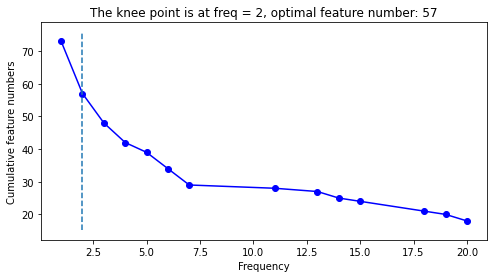

In [18]:
def find_knee(df):
    slopes = (df['accum'].diff(-1)) / (df['freq'].diff(-1))*(-1)
    knee_index = slopes.idxmax()
    return knee_index

knee_index = find_knee(features_freq)
knee_freq = features_freq.loc[knee_index]['freq']

# import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(features_freq['freq'], features_freq['accum'], 'bo-')  # blue dots with line
plt.xlabel('Frequency')
plt.ylabel('Cumulative feature numbers')
plt.title(f"The knee point is at freq = {knee_freq}, optimal feature number: {features_freq.loc[knee_index]['accum']}")
plt.vlines(knee_freq, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

In [19]:
selected_features = feature_list[feature_list['freq']>=knee_freq]['feature'].tolist()
with open('/mnt/inca/soc_eu_model/data/004.1_selected.covar_all.rank.freq.txt', 'w') as file:
    for item in selected_features:
        file.write(f"{item}\n")

### for only annual covariates

In [26]:
result = run_rankcv(dff, covs_annual, tgt, spatial_cv_column='tile_id')
feature_list = result.groupby(['feature']).count().rename(columns=dict(importance='freq')).reset_index()

features_freq = feature_list.groupby('freq').count().reset_index().sort_values(by='freq', ascending=False)
features_freq['accum'] = features_freq['feature'].cumsum()
features_freq

[15:31:40] 0 iteration, training size: 51168
[15:31:53] 1 iteration, training size: 51990
[15:32:06] 2 iteration, training size: 51514
[15:32:18] 3 iteration, training size: 51700
[15:32:31] 4 iteration, training size: 51779
[15:32:44] 5 iteration, training size: 51669
[15:32:57] 6 iteration, training size: 51650
[15:33:27] 7 iteration, training size: 51373
[15:33:55] 8 iteration, training size: 52115
[15:34:10] 9 iteration, training size: 51759
[15:34:24] 10 iteration, training size: 51775
[15:34:53] 11 iteration, training size: 51275
[15:35:22] 12 iteration, training size: 52008
[15:35:36] 13 iteration, training size: 51664
[15:35:49] 14 iteration, training size: 51575
[15:36:03] 15 iteration, training size: 51729
[15:36:21] 16 iteration, training size: 51468
[15:36:37] 17 iteration, training size: 51892
[15:36:52] 18 iteration, training size: 51396
[15:37:07] 19 iteration, training size: 51558


,freq,feature,accum
11,20,40,40
10,19,3,43
9,17,2,45
8,16,2,47
7,15,2,49
6,12,1,50
5,10,2,52
4,6,2,54
3,4,1,55
2,3,1,56


In [27]:
print(feature_list.sort_values(by='freq', ascending=False).to_string())

                                                                                                   feature  freq
0                                          clm_accum.precipitation_chelsa.annual_m_1km_s0..0cm_{year}_v2.1    20
23                                                clm_bioclim.var_chelsa.gsp_m_1km_s0..0cm_1981..2010_v2.1    20
27                                                     clm_lst_mod11a2.daytime_p50_1km_s0..0cm_{year}_v1.2    20
28                                                     clm_lst_mod11a2.daytime_p95_1km_s0..0cm_{year}_v1.2    20
29                                                      clm_lst_mod11a2.daytime_sd_1km_s0..0cm_{year}_v1.2    20
30                                                   clm_lst_mod11a2.nighttime_p05_1km_s0..0cm_{year}_v1.2    20
32                                                   clm_lst_mod11a2.nighttime_p95_1km_s0..0cm_{year}_v1.2    20
33                                                    clm_lst_mod11a2.nighttime_sd_1km_s0..0cm_{

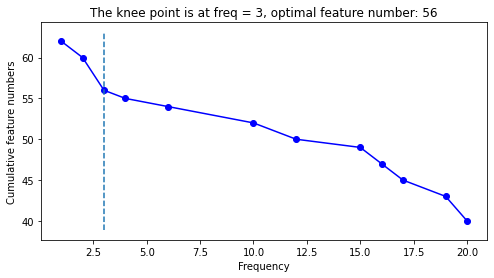

In [28]:
def find_knee(df):
    slopes = (df['accum'].diff(-1)) / (df['freq'].diff(-1))*(-1)
    knee_index = slopes.idxmax()
    return knee_index

knee_index = find_knee(features_freq)
knee_freq = features_freq.loc[knee_index]['freq']

# import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(features_freq['freq'], features_freq['accum'], 'bo-')  # blue dots with line
plt.xlabel('Frequency')
plt.ylabel('Cumulative feature numbers')
plt.title(f"The knee point is at freq = {knee_freq}, optimal feature number: {features_freq.loc[knee_index]['accum']}")
plt.vlines(knee_freq, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

In [29]:
selected_features = feature_list[feature_list['freq']>=knee_freq]['feature'].tolist()
with open('/mnt/inca/soc_eu_model/data/004.2_selected.covar_annual.rank.freq.txt', 'w') as file:
    for item in selected_features:
        file.write(f"{item}\n")

In [30]:
selected_features

['clm_accum.precipitation_chelsa.annual_m_1km_s0..0cm_{year}_v2.1',
 'clm_bioclim.var_chelsa.bio10_m_1km_s0..0cm_1981..2010_v2.1',
 'clm_bioclim.var_chelsa.bio11_m_1km_s0..0cm_1981..2010_v2.1',
 'clm_bioclim.var_chelsa.bio12_m_1km_s0..0cm_1981..2010_v2.1',
 'clm_bioclim.var_chelsa.bio13_m_1km_s0..0cm_1981..2010_v2.1',
 'clm_bioclim.var_chelsa.bio14_m_1km_s0..0cm_1981..2010_v2.1',
 'clm_bioclim.var_chelsa.bio15_m_1km_s0..0cm_1981..2010_v2.1',
 'clm_bioclim.var_chelsa.bio16_m_1km_s0..0cm_1981..2010_v2.1',
 'clm_bioclim.var_chelsa.bio17_m_1km_s0..0cm_1981..2010_v2.1',
 'clm_bioclim.var_chelsa.bio18_m_1km_s0..0cm_1981..2010_v2.1',
 'clm_bioclim.var_chelsa.bio19_m_1km_s0..0cm_1981..2010_v2.1',
 'clm_bioclim.var_chelsa.bio2_m_1km_s0..0cm_1981..2010_v2.1',
 'clm_bioclim.var_chelsa.bio3_m_1km_s0..0cm_1981..2010_v2.1',
 'clm_bioclim.var_chelsa.bio4_m_1km_s0..0cm_1981..2010_v2.1',
 'clm_bioclim.var_chelsa.bio5_m_1km_s0..0cm_1981..2010_v2.1',
 'clm_bioclim.var_chelsa.bio6_m_1km_s0..0cm_1981..2010